In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [238]:
sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

In [239]:
os.getcwd()

'/Users/chance/Desktop/LH_home/ksc'

In [335]:
folder = os.listdir()

file = []
for f in folder:
    if "단독다가구" in f:
        data = pd.read_csv("./" + f, encoding="cp949", skiprows=15)
        data = data[list(data.columns[:11])]
        file.append(data)

gajwa = pd.concat(file)
gajwa = gajwa.dropna(axis=0)

# 도로조건을 정수로 변환
road=[]
for a in gajwa["도로조건"]:
    if a=="-":
        a = "0"
    road.append(int(a.split("m")[0]))
gajwa["도로조건"] = road


# 년월 column 생성
year=[]
month=[]
for d in gajwa["계약년월"]:
    day = pd.to_datetime(d, format="%Y%m")
    year.append(day.year)
    month.append(day.month)

gajwa["year"] = year
gajwa["month"] = month

built_day = [pd.to_datetime(d, format="%Y").year for d in gajwa["건축년도"]]
gajwa["건축년도"] = built_day

# 위치 column만들기
gajwa["location"] = gajwa.시군구 + " " + gajwa.도로명


#원핫인코딩으로 전월세 구분하기
gajwa = pd.get_dummies(gajwa, columns = ["전월세구분"])
#gajwa = pd.get_dummies(gajwa, columns = ["도로명"])

# 계약년월 기준으로 전월세전환율 입력하기
rate = pd.read_csv("./지역별_전월세전환율_20221112193907.csv", encoding="cp949")
rate = rate.T
rate = rate[2:]

month = []
for r in rate.index:
    new = "".join(r.split("."))
    month.append(int(new))

rate["계약년월"] = month
rate.columns = ["전월세전환율", "계약년월"]
rate.head()

gajwa = pd.merge(left=gajwa, right=rate, how="inner", on="계약년월")

keep = [int("".join(k.split(","))) for k in gajwa["보증금(만원)"]]
gajwa["보증금(만원)"] = keep


# 전월세전환율 기준으로 보증금+월세의 가치를 전세로 치환하여 value column으로 만들어준다.
value=[round(gajwa["월세(만원)"][i] * 12 / (gajwa["전월세전환율"][i]/100) + gajwa["보증금(만원)"][i]) for i in range(len(gajwa))]
gajwa["전세전환가격"] = value
#gajwa["도로별 전세값평균"] = gajwa.groupby("도로명").전세전환가격.transform("mean")


# 도로명 결측치 제거
indexNames = []
for i in range(len(gajwa["도로명"])):
    if "번길" not in gajwa["도로명"][i]:
        indexNames.append(i)

gajwa.drop(indexNames, inplace=True)
gajwa

,시군구,번지,도로조건,계약면적(㎡),계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,year,month,location,전월세구분_월세,전월세구분_전세,전월세전환율,전세전환가격
0,경상남도 진주시 가좌동,1***,8,12.00,202001,19,200,36,2019,가좌길60번길,2020,1,경상남도 진주시 가좌동 가좌길60번길,1,0,7.0,6371
1,경상남도 진주시 가좌동,1***,8,16.00,202001,22,4000,0,2015,가좌길78번길,2020,1,경상남도 진주시 가좌동 가좌길78번길,0,1,7.0,4000
2,경상남도 진주시 가좌동,1***,12,17.00,202001,13,6000,5,2019,가좌길36번길,2020,1,경상남도 진주시 가좌동 가좌길36번길,1,0,7.0,6857
3,경상남도 진주시 가좌동,1***,8,20.00,202001,2,300,35,2016,가좌길48번길,2020,1,경상남도 진주시 가좌동 가좌길48번길,1,0,7.0,6300
4,경상남도 진주시 가좌동,4**,12,20.00,202001,2,500,40,2014,개양로6번길,2020,1,경상남도 진주시 가좌동 개양로6번길,1,0,7.0,7357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,경상남도 진주시 가좌동,1***,12,25.00,202011,29,2000,5,2009,진주대로404번길,2020,11,경상남도 진주시 가좌동 진주대로404번길,1,0,6.6,2909
1616,경상남도 진주시 가좌동,1***,12,25.00,202011,14,5000,0,2017,가좌길64번길,2020,11,경상남도 진주시 가좌동 가좌길64번길,0,1,6.6,5000
1617,경상남도 진주시 가좌동,1***,8,30.00,202011,27,2000,20,2019,내동로320번길,2020,11,경상남도 진주시 가좌동 내동로320번길,1,0,6.6,5636
1618,경상남도 진주시 가좌동,1***,12,36.30,202011,26,300,55,1996,가좌길36번길,2020,11,경상남도 진주시 가좌동 가좌길36번길,1,0,6.6,10300


In [336]:
# # 전세 월세 구분 데이터셋
# gajwa = gajwa[gajwa.전월세구분 == "월세"]
# gajwa = pd.DataFrame.drop(gajwa, columns=["전월세구분"], axis=1)
# gajwa

## 지도

In [ ]:
# 위경도를 이용한 거리구하기

geocoding = pd.read_csv("./geocoding.csv")
gajwa["경도"] = geocoding.X
gajwa["위도"] = geocoding.Y
gajwa = gajwa.dropna(axis=0)
gajwa

In [380]:
from haversine import haversine

gnu_long = 35.1530444
gnu_lat = 128.1010899

haversine((gajwa["위도"], gajwa["경도"]), (gnu_lat, gnu_long))

ModuleNotFoundError: No module named 'haversine'

In [351]:
import folium
long = []
lat = []


# m = folium.Map(location=[gnu_long, gnu_lat], zoom_start=20)
# folium.Marker([gnu_long, gnu_lat]).add_to(m)
# folium.Marker([test_long, test_lat]).add_to(m)
# m

,시군구,번지,도로조건,계약면적(㎡),계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,year,month,location,전월세구분_월세,전월세구분_전세,전월세전환율,전세전환가격,경도,위도
0,경상남도 진주시 가좌동,1***,8,12.00,202001,19,200,36,2019,가좌길60번길,2020,1,경상남도 진주시 가좌동 가좌길60번길,1,0,7.0,6371,128.105889,35.157466
1,경상남도 진주시 가좌동,1***,8,16.00,202001,22,4000,0,2015,가좌길78번길,2020,1,경상남도 진주시 가좌동 가좌길78번길,0,1,7.0,4000,128.105889,35.157466
2,경상남도 진주시 가좌동,1***,12,17.00,202001,13,6000,5,2019,가좌길36번길,2020,1,경상남도 진주시 가좌동 가좌길36번길,1,0,7.0,6857,128.105966,35.156961
3,경상남도 진주시 가좌동,1***,8,20.00,202001,2,300,35,2016,가좌길48번길,2020,1,경상남도 진주시 가좌동 가좌길48번길,1,0,7.0,6300,128.105966,35.156961
4,경상남도 진주시 가좌동,4**,12,20.00,202001,2,500,40,2014,개양로6번길,2020,1,경상남도 진주시 가좌동 개양로6번길,1,0,7.0,7357,128.106121,35.158214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,경상남도 진주시 가좌동,1***,8,25.00,202102,17,4500,0,2018,가좌길44번길,2021,2,경상남도 진주시 가좌동 가좌길44번길,0,1,7.2,4500,128.099898,35.158679
1352,경상남도 진주시 가좌동,1***,8,26.50,202102,18,300,35,2021,가좌길60번길,2021,2,경상남도 진주시 가좌동 가좌길60번길,1,0,7.2,6133,128.103328,35.145290
1354,경상남도 진주시 가좌동,1***,8,27.43,202102,20,300,25,2012,가좌길78번길,2021,2,경상남도 진주시 가좌동 가좌길78번길,1,0,7.2,4467,128.106519,35.160476
1355,경상남도 진주시 가좌동,4**,12,28.00,202102,9,200,30,2010,개양로13번길,2021,2,경상남도 진주시 가좌동 개양로13번길,1,0,7.2,5200,128.106121,35.158214


In [338]:
gajwa_data = pd.DataFrame.drop(gajwa, columns=["시군구","계약년월", "번지", "도로명", "계약일", "보증금(만원)", "월세(만원)", "location"], axis=1)

gajwa_data

,도로조건,계약면적(㎡),건축년도,year,month,전월세구분_월세,전월세구분_전세,전월세전환율,전세전환가격,경도,위도
0,8,12.00,2019,2020,1,1,0,7.0,6371,35.157466,128.105889
1,8,16.00,2015,2020,1,0,1,7.0,4000,35.157466,128.105889
2,12,17.00,2019,2020,1,1,0,7.0,6857,35.156961,128.105966
3,8,20.00,2016,2020,1,1,0,7.0,6300,35.156961,128.105966
4,12,20.00,2014,2020,1,1,0,7.0,7357,35.158214,128.106121
...,...,...,...,...,...,...,...,...,...,...,...
1351,8,25.00,2018,2021,2,0,1,7.2,4500,35.158679,128.099898
1352,8,26.50,2021,2021,2,1,0,7.2,6133,35.145290,128.103328
1354,8,27.43,2012,2021,2,1,0,7.2,4467,35.160476,128.106519
1355,12,28.00,2010,2021,2,1,0,7.2,5200,35.158214,128.106121


# 머신러닝

In [352]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
import catboost
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [353]:
X = gajwa_data.drop(["전세전환가격"], axis=1)
y = gajwa_data['전세전환가격']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1645)

scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.fit_transform(X_test)

# minmaxScaler = MinMaxScaler()
# X_train_standardized2 = minmaxScaler.fit_transform(X_train)
# X_test_standardized2 = minmaxScaler.fit_transform(X_test)

## 선형회귀분석

In [354]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_preds = lr.predict(X_test)

# mse = mean_squared_error(y_test, y_preds)
# rmse = np.sqrt(mse)

# print(f"MSE : {mse:.3f}", f"RMSE: {rmse:.3f}")
# print(f"variance score : {r2_score(y_test, y_preds):.3f}")

In [355]:
# lr.fit(X_train_standardized, y_train)
# lr.score(X_test_standardized, y_test)

## Ridge

In [356]:
# R_model = Ridge()
# R_model.fit(X_train, y_train)
# print(R_model.score(X_test, y_test))

# R_model.fit(X_train_standardized, y_train)
# R_model.score(X_test_standardized, y_test)

## Lasso

In [357]:
# L_model = Lasso(alpha=0.5)
# L_model.fit(X_train, y_train)
# print(L_model.score(X_test, y_test))

# L_model.fit(X_train_standardized, y_train)
# L_model.score(X_test_standardized, y_test)

## ElasticNet

In [358]:
# ela = ElasticNet(alpha=0.5)
# ela.fit(X_train, y_train)
# print(ela.score(X_test, y_test))

# ela.fit(X_train_standardized, y_train)
# ela.score(X_test_standardized, y_test)

## 랜덤포레스트

In [370]:
randomforest = RandomForestRegressor(random_state=0, n_jobs=-1)
randomforest_model = randomforest.fit(X_train, y_train)
print(randomforest_model.score(X_test, y_test))

randomforest_model = randomforest.fit(X_train_standardized, y_train)
print(randomforest_model.score(X_test_standardized, y_test))

# randomforest_model = randomforest.fit(X_train_standardized2, y_train)
# randomforest_model.score(X_test_standardized2, y_test)

0.6797946933202446
0.6411368348784341


In [360]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor()
gbm.fit(X_train_standardized, y_train)
gbm.score(X_test_standardized, y_test)

0.6027108187328014

In [371]:
lightgbm = lgb.LGBMRegressor()
lightgbm.fit(X_train_standardized, y_train)
print(lightgbm.score(X_test_standardized, y_test))

# lightgbm.fit(X_train_standardized2, y_train)
# print(lightgbm.score(X_test_standardized2, y_test))

0.6341498183328256


## XGBoost

In [372]:
gajwa_copy = pd.DataFrame.drop(gajwa, columns=["시군구","계약년월", "번지", "도로명", "계약일", "보증금(만원)", "월세(만원)", "location", "전월세전환율"], axis=1)
gajwa_copy

X = gajwa_copy.drop(["전세전환가격"], axis=1)
y = gajwa_copy['전세전환가격']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1645)

scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.fit_transform(X_test)

xgboost = XGBRegressor(n_estimators=30)
xgboost.fit(X_train, y_train)
print(xgboost.score(X_test, y_test))

xgboost.fit(X_train_standardized, y_train)
xgboost.score(X_test_standardized, y_test)

0.6065738045015958


/Users/chance/opt/anaconda3/envs/py3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.5409138516983414

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

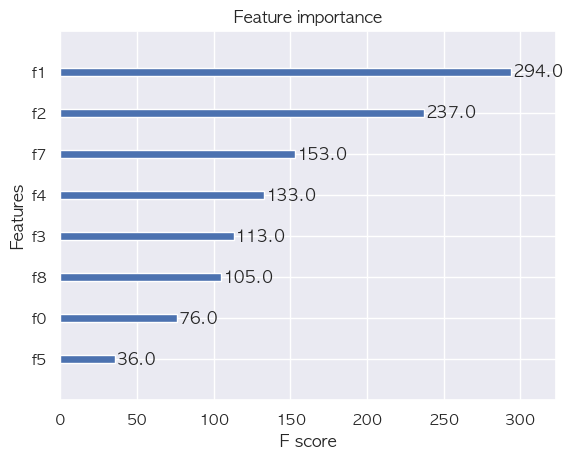

In [373]:
plot_importance(xgboost)

In [374]:
cb = catboost.CatBoostRegressor()
cb.fit(X_train_standardized, y_train)
cb.score(X_test_standardized, y_test)

Learning rate set to 0.040295
0:	learn: 1966.8312038	total: 2.88ms	remaining: 2.88s
1:	learn: 1928.9910225	total: 3.17ms	remaining: 1.58s
2:	learn: 1889.8952033	total: 3.45ms	remaining: 1.15s
3:	learn: 1853.9394676	total: 3.74ms	remaining: 930ms
4:	learn: 1822.6737547	total: 3.97ms	remaining: 791ms
5:	learn: 1792.3082015	total: 4.21ms	remaining: 697ms
6:	learn: 1765.3312358	total: 4.47ms	remaining: 634ms
7:	learn: 1735.7093317	total: 4.72ms	remaining: 585ms
8:	learn: 1708.8220645	total: 5.06ms	remaining: 557ms
9:	learn: 1684.1765002	total: 5.26ms	remaining: 521ms
10:	learn: 1656.5868375	total: 5.82ms	remaining: 523ms
11:	learn: 1633.5105935	total: 6.12ms	remaining: 504ms
12:	learn: 1612.5018552	total: 6.49ms	remaining: 493ms
13:	learn: 1590.0034392	total: 6.79ms	remaining: 478ms
14:	learn: 1569.7138571	total: 7.53ms	remaining: 495ms
15:	learn: 1552.1663139	total: 8.27ms	remaining: 509ms
16:	learn: 1534.4931526	total: 8.79ms	remaining: 508ms
17:	learn: 1517.2887619	total: 9.17ms	remaini

0.6457181807522746

## 데이터시각화

In [375]:
corr = gajwa_data.corr()
corr

,도로조건,계약면적(㎡),건축년도,year,month,전월세구분_월세,전월세구분_전세,전세전환가격,경도,위도
도로조건,1.000000,0.094036,-0.204971,-0.000379,0.000318,0.056497,-0.056497,0.091577,-0.021290,-0.008364
계약면적(㎡),0.094036,1.000000,-0.128572,-0.086882,0.107948,-0.015222,0.015222,0.663270,0.039183,0.021114
건축년도,-0.204971,-0.128572,1.000000,0.137885,-0.025935,-0.158912,0.158912,-0.053028,-0.015457,-0.000964
year,-0.000379,-0.086882,0.137885,1.000000,-0.300259,0.015542,-0.015542,-0.064654,-0.011355,0.002690
month,0.000318,0.107948,-0.025935,-0.300259,1.000000,-0.049696,0.049696,0.074066,-0.005814,0.023344
전월세구분_월세,0.056497,-0.015222,-0.158912,0.015542,-0.049696,1.000000,-1.000000,0.340387,0.037909,0.027947
전월세구분_전세,-0.056497,0.015222,0.158912,-0.015542,0.049696,-1.000000,1.000000,-0.340387,-0.037909,-0.027947
전세전환가격,0.091577,0.663270,-0.053028,-0.064654,0.074066,0.340387,-0.340387,1.000000,0.047306,0.047634
경도,-0.021290,0.039183,-0.015457,-0.011355,-0.005814,0.037909,-0.037909,0.047306,1.000000,0.446256
위도,-0.008364,0.021114,-0.000964,0.002690,0.023344,0.027947,-0.027947,0.047634,0.446256,1.000000


## 카카오맵api